In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import ShapePreprocess
import glob

2022-11-21 21:59:12.358596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 21:59:12.781063: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 21:59:14.059677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/apps/cuda/11.3/lib64
2022-11-21 21:59:14.064249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.s

## Load Data

In [2]:
# 알약 이미지 파일 경로 불러오기 (x)
filepaths = sorted(glob.glob('../../Data/separate/front/*.png')) + sorted(glob.glob('../../Data/separate/back/*.png'))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)

# 알약 모양 목록 불러오기 (y)
labels = pd.read_csv("../../Data/pill_kr_reduce.csv", encoding='utf-8')[['DRUG_SHAPE']]
labels = pd.concat((labels.DRUG_SHAPE, labels.DRUG_SHAPE), axis=0).reset_index(drop=True)
labels = pd.Series(labels, name='Label').astype(str)

/tmp/ipykernel_160343/710320517.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv("../../Data/pill_kr_reduce.csv", encoding='utf-8')[['DRUG_SHAPE']]


In [3]:
df = pd.concat([filepaths, labels], axis=1)
df

,Filepath,Label
0,../../Data/separate/front/front_00001.png,원형
1,../../Data/separate/front/front_00002.png,원형
2,../../Data/separate/front/front_00003.png,장방형
3,../../Data/separate/front/front_00004.png,원형
4,../../Data/separate/front/front_00005.png,원형
...,...,...
46635,../../Data/separate/back/back_23316.png,타원형
46636,../../Data/separate/back/back_23317.png,타원형
46637,../../Data/separate/back/back_23318.png,원형
46638,../../Data/separate/back/back_23319.png,원형


## EDA

In [11]:
print(f'Number of images: {len(df)}')
print(f'Number of different shapes: {len(df.Label.unique())}')
print(f'Shapes: {df.Label.unique()}')

Number of images: 46640
Number of different shapes: 11
Shapes: ['원형' '장방형' '타원형' '팔각형' '오각형' '삼각형' '기타' '마름모형' '사각형' '육각형' '반원형']


/tmp/ipykernel_157463/786781225.py:8: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout(pad=0.5)
/tmp/ipykernel_157463/786781225.py:8: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  plt.tight_layout(pad=0.5)
/tmp/ipykernel_157463/786781225.py:8: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  plt.tight_layout(pad=0.5)
/tmp/ipykernel_157463/786781225.py:8: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  plt.tight_layout(pad=0.5)
/tmp/ipykernel_157463/786781225.py:8: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  plt.tight_layout(pad=0.5)
/opt/ohpc/pub/libs/miniconda3/envs/jupyterhub/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ohpc/pub/libs/miniconda3/envs/jupyterhub/li

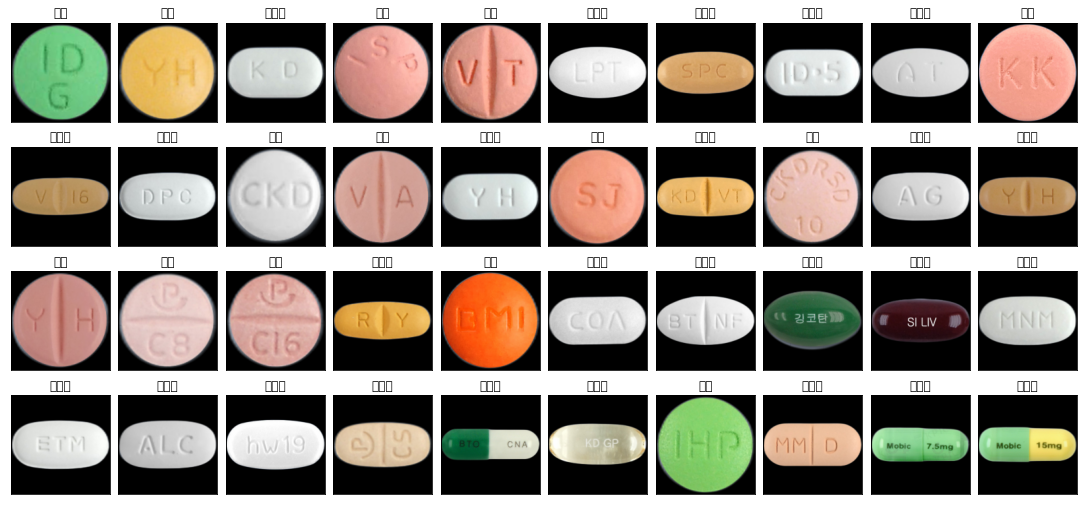

In [12]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

/opt/ohpc/pub/libs/miniconda3/envs/jupyterhub/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ohpc/pub/libs/miniconda3/envs/jupyterhub/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ohpc/pub/libs/miniconda3/envs/jupyterhub/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ohpc/pub/libs/miniconda3/envs/jupyterhub/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/ohpc/pub/libs/miniconda3/envs/jupyterhub/lib/python3.9/site-packages/IPython/core/pyl

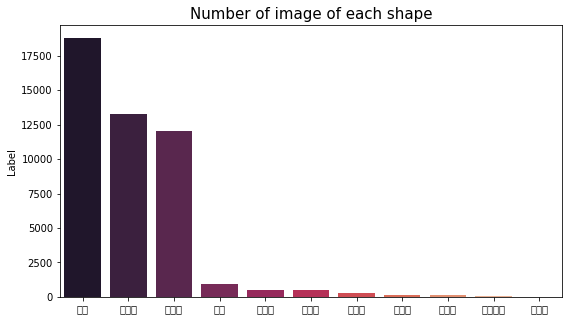

In [13]:
# 데이터 분포
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of image of each shape", fontsize = 15)
plt.show()

## Make Train Data

In [7]:
x = []
y = []
class_num = 0
class_dict = dict()

for i, row in df.iterrows():
    if i % 1000 == 0:
        print(i)
    
    if row['Label'] not in class_dict.keys():
        class_dict[row['Label']] = len(class_dict)
    y.append(class_dict[row['Label']])
    class_num += 1
    
    img = cv.imread(row['Filepath'], cv.IMREAD_GRAYSCALE)
    ret, thr = cv.threshold(img, 5, 255, cv.THRESH_BINARY)
    x.append(thr)
    
x = np.array(x)
y = np.array(y)

print("x_train shape:", x.shape)
print("y_train shape:", y.shape)
print("class number:", class_num)
print("class list:",class_dict)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
x_train shape: (46640, 150, 150)
y_train shape: (46640,)
class number: 46640
class list: {'원형': 0, '장방형': 1, '타원형': 2, '팔각형': 3, '오각형': 4, '삼각형': 5, '기타': 6, '마름모형': 7, '사각형': 8, '육각형': 9, '반원형': 10}


In [8]:
# 학습 데이터 저장
np.savez('data.npz',x=x,y=y)

## Update Label to csv

In [18]:
# 레이블 데이터 불러오기
df = pd.read_csv("../../Data/pill_labels.csv", encoding='utf-8')

In [15]:
df['Shape'] = 0

In [16]:
data_num = len(df)

for i in range(data_num):
    df.loc[i, 'Shape'] = y[i]
df

,ITEM_SEQ,ITEM_NAME,PRINT_FRONT,PRINT_BACK,Shape
0,200808876,가스디알정50밀리그램(디메크로틴산마그네슘),0,322,0
1,200808877,페라트라정2.5밀리그램(레트로졸),1,977,0
2,200809076,가스프렌정(모사프리드시트르산염이수화물),2,46,1
3,200809276,디텐션정80밀리그램(발사르탄),3,3633,0
4,200809361,바르탄정(발사르탄),4,12867,0
...,...,...,...,...,...
23315,202104524,에소리움플러스정20/800밀리그램,11949,3713,2
23316,202104996,글루파엑스알서방정850밀리그램(메트포르민염산염),10593,13366,2
23317,201601206,크레아진플러스정10/20mg,618,322,0
23318,202102255,빌다글립엠정50밀리그램(빌다글립틴),1132,11883,0


In [17]:
df.to_csv("../../Data/pill_labels.csv", encoding='utf-8', index=False)